# Runner Times: base scenario

THis notebook shows the connections between doors in the histopathology lab as a graph,
and computes the runner time between stages based on this logical graph, based on the given
configuration.

In [1]:
import re
import pandas as pd
import openpyxl

from histopath_bim_des.bim import BimModel, runner_times, logical_graph
from histopath_bim_des.config.runners import RunnerConfig
import histopath_bim_des.excel as excel
import networkx as ntx

**NOTE:** running this notebook requires a copy of "histo.ifc", which is not shared publically due
to confidentially concerns.

In [2]:
model = BimModel.from_ifc('../assets/private/histo.ifc')
runner_cfg_path = '../assets/histo.xlsx'

In [3]:
# NOTE: If an error occurs, try re-saving this file to force Excel to recalculate formulas
cfg = RunnerConfig.from_excel(openpyxl.load_workbook(runner_cfg_path, data_only=True))

rt = runner_times(model, cfg)

[[0.25], [0.25], [0.25], [0.25]]


In [4]:
df = pd.DataFrame(
    [[str(k).replace("'",''), v] for k,v in rt.items()],
    columns=['runner_journey', 'runner_time']
)
df

,runner_journey,runner_time
0,"(reception, cutup)",8.452306
1,"(cutup, processing)",6.968697
2,"(processing, microtomy)",28.089256
3,"(microtomy, staining)",3.678511
4,"(staining, labelling)",3.678511
5,"(labelling, scanning)",86.898479
6,"(scanning, qc)",86.898479


In [5]:
# Comparison
cfg2:RunnerConfig = cfg.model_copy()
cfg2.runner_speed = 1.0
rt2 = runner_times(model, cfg2)
df2 = pd.DataFrame(
    [[str(k).replace("'",''), v] for k,v in rt2.items()],
    columns=['runner_journey', 'runner_time']
)
df2

,runner_journey,runner_time
0,"(reception, cutup)",10.142767
1,"(cutup, processing)",8.362437
2,"(processing, microtomy)",33.707107
3,"(microtomy, staining)",4.414214
4,"(staining, labelling)",4.414214
5,"(labelling, scanning)",95.278175
6,"(scanning, qc)",95.278175


In [6]:
# excel.write_table(df, runner_cfg_path, 'Runner Times output', 'tableRunnerTimes')

# Logical graph of doors

In [7]:
target_levels = [re.match(r'Level (\d+)', s).group(1) for s in model.doors.floor.unique()]
logical_graphs = {level: logical_graph(model.to_shapely(level=level), cfg.runner_speed) for level in target_levels}
full_logical_graph = ntx.compose_all(logical_graphs.values())
for path in cfg.extra_paths: full_logical_graph.add_edge(*path.path, weight=path.duration_seconds)

{('d10', 'd12'): Text(0.603556644183344, -0.35356394371172106, 'stairs'),
 ('d11', 'd13'): Text(0.8535499403100648, 0.3535617870752734, 'lift')}

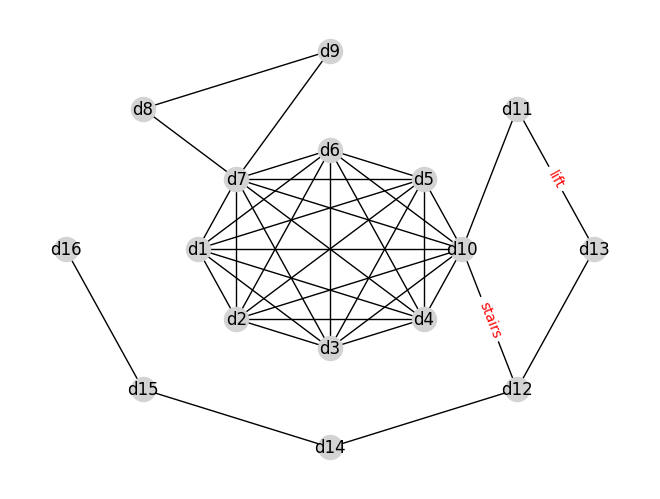

In [8]:
shells = [['d6', 'd7', 'd1', 'd2', 'd3', 'd4', 'd10', 'd5'], ['d16', 'd15', 'd14', 'd12', 'd13', 'd11', 'd9', 'd8']]
positions = ntx.shell_layout(full_logical_graph, shells)
ntx.draw(full_logical_graph, positions, with_labels= True, font_color='black', node_color='lightgray')

ntx.draw_networkx_edge_labels(
    full_logical_graph, positions,
    edge_labels={('d10', 'd12'): 'stairs', 
                 ('d11', 'd13'): 'lift'},
    font_color='red'
)

## Runner times: heatmap

In [9]:
mat = ntx.adjacency_matrix(full_logical_graph).todense()

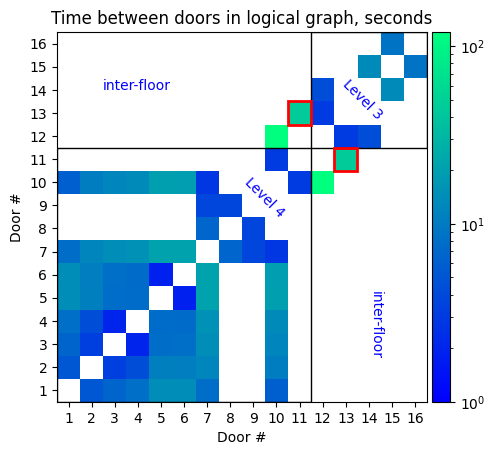

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(mat, interpolation="nearest", origin="lower",
           cmap='winter', norm=LogNorm(vmin=1, vmax=120))
ax.add_patch(Rectangle((-0.5,-0.5), 11, 11, fill=False, edgecolor='k'))
ax.add_patch(Rectangle((10.5,10.5), 5, 5, fill=False, edgecolor='k'))

ax.add_patch(Rectangle((9.5,11.5), 1, 1, fill=False, edgecolor='r', linewidth=2))
ax.add_patch(Rectangle((11.5,9.5), 1, 1, fill=False, edgecolor='r', linewidth=2))

ax.text(1.5,13,'inter-floor', color='b')
ax.text(7.5,7.5,'Level 4', color='b', rotation=-45)
ax.text(13,1.5,'inter-floor', rotation=-90, color='b')
ax.text(11.75,11.75,'Level 3', color='b', rotation=-45)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel('Door #')
ax.set_ylabel('Door #')
ax.set_title('Time between doors in logical graph, seconds')
ax.set_xticks(range(16), range(1,17))
ax.set_yticks(range(16), range(1,17))

The highlighted squares in the above figure correspond to the lift and are removed when the
lift is down.

In [11]:
full_logical_graph

In [12]:
ntx.write_gml(full_logical_graph, 'graph.gml')